## Vehicle Detection and Tracking

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time
from skimage.feature import hog
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

In [5]:
# Read in car and non-car images
non_car_images = glob.glob('non-vehicles/**/*.png')
car_images = glob.glob('vehicles/**/*.png')
cars = []
notcars = []
for img_file in non_car_images:
    notcars.append(img_file)
for img_file in car_images:
    cars.append(img_file)

In [6]:
print(len(non_car_images))
print(len(car_images))

8968
8792


## Color Classifier Features

In [7]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

In [8]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))    
    return hist_features

## HOG Classifier Features

In [9]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

## Combined Classification (HOG + Color)

In [10]:
# Extracts features from a single image window
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [11]:
# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        file_features = single_img_features(image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

        features.append(file_features)
    # Return list of feature vectors
    return features

In [117]:
def show_hog_features(img):   

    ncols = 2
    nrows = 6
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches(10.5, 35.5)
    feature_image = img
    
    i = 0
    for color_space in ["RGB", "HSV", "LUV", "HLS", "YUV", "YCrCb"]:
        if color_space == "HSV":
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
        features, hog_img =  get_hog_features(feature_image[:,:,0], orient=9, pix_per_cell=8, cell_per_block=8, 
                                    vis=True, feature_vec=True)

        axes[i][0].imshow(img)
        axes[i][0].set_title(color_space)
        axes[i][1].imshow(hog_img)            

        i += 1
    plt.show()


### Non-Car Hog Features

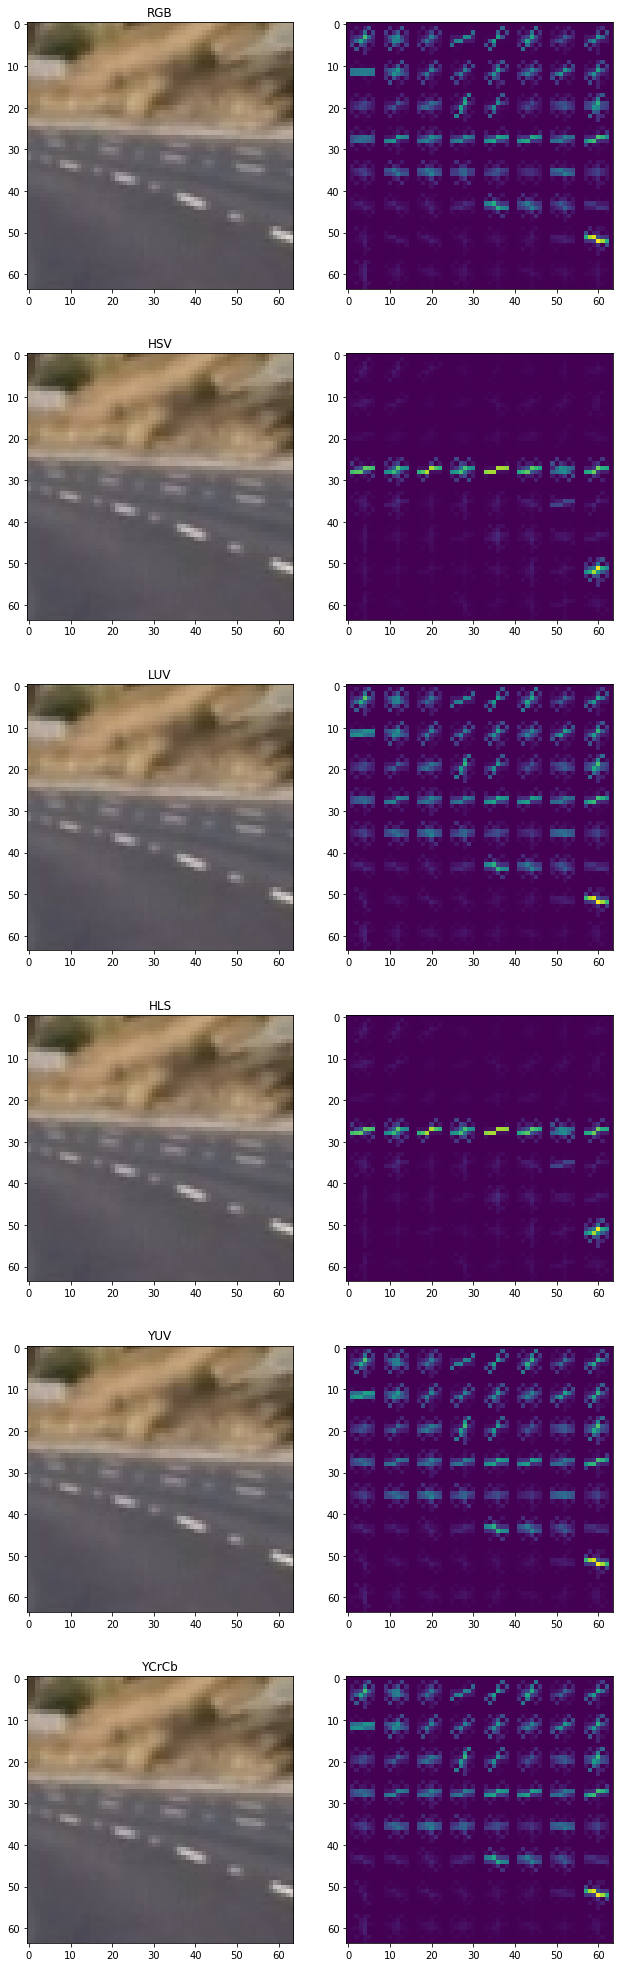

In [118]:
image = mpimg.imread(non_car_images[2])
show_hog_features(image)
            

### Car Hog Features

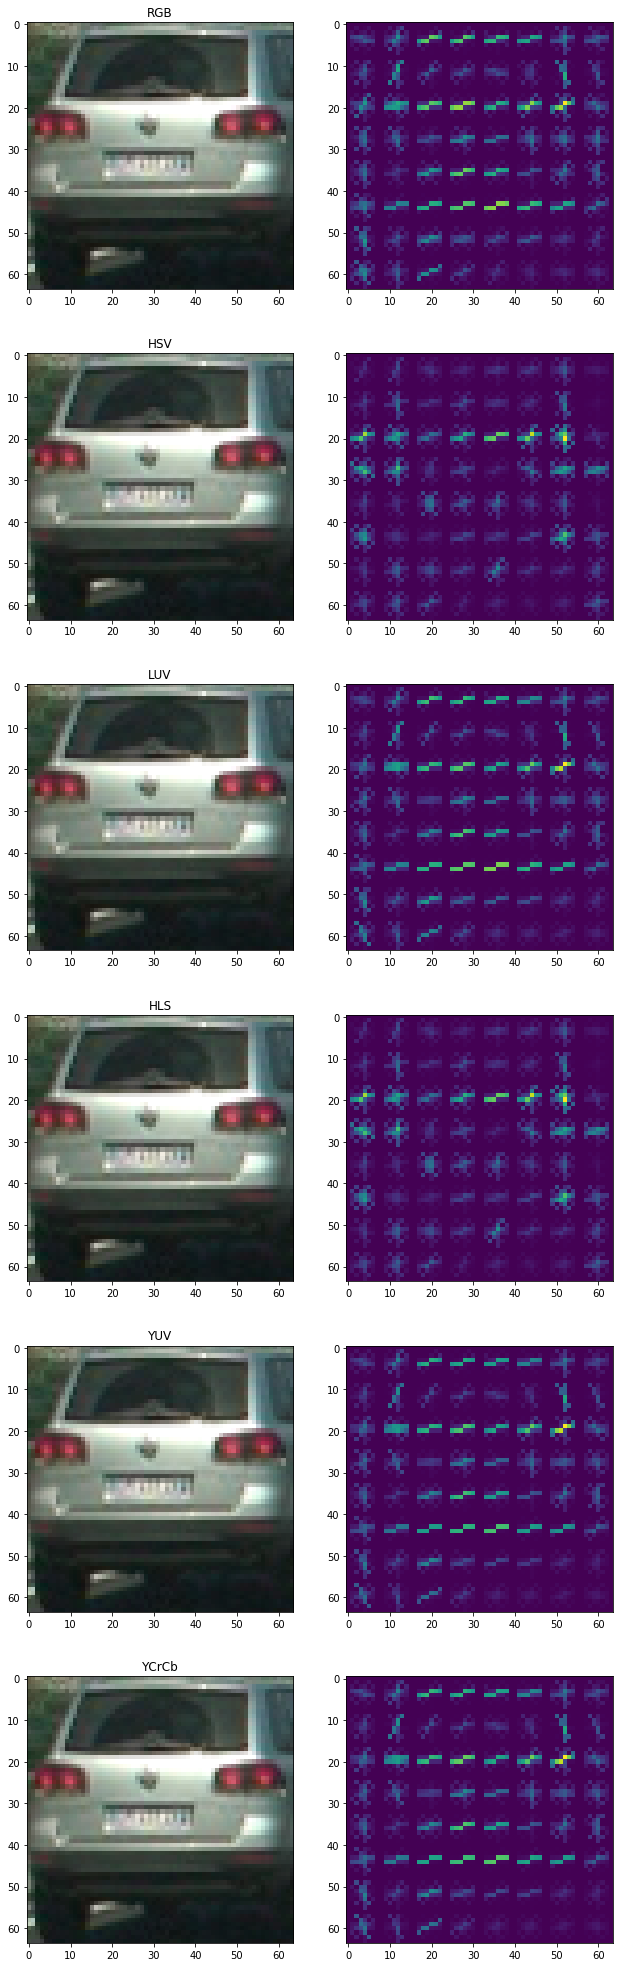

In [119]:
image = mpimg.imread(car_images[200])
show_hog_features(image)            

## Classifier

In [16]:
def get_classifier(car_features, notcar_features):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = X_test.shape[0]
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return svc, X_scaler

In [17]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [18]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [19]:
classifier, X_scaler = get_classifier(car_features, notcar_features)

Feature vector length: 8460
5.09 Seconds to train SVC...
Test Accuracy of SVC =  0.989
0.0 Seconds to predict 3552 labels with SVC


pix_per_cell = 16
Test Accuracy of SVC =  0.9825

orient=13
Test Accuracy of SVC =  0.9854

pix_per_cell = 8
Test Accuracy of SVC =  0.991

## Sliding Windows

In [ ]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins):
    
    bboxes = [] #array of boxes with cars
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))               
                
    return bboxes

## Test Feature Detection

In [21]:
# Read in test images
test_image_files = glob.glob('test_images/*.jpg')
test_images = []
for img_file in test_image_files:
    test_images.append(img_file)

In [22]:
def view_image_w_boxes(image, ystart, ystop, scale):    
    print("Scale: ",scale)
    
    bboxes = find_cars(image, ystart, ystop, scale, classifier, X_scaler, orient, 
                        pix_per_cell, cell_per_block, spatial_size, hist_bins)

    for bbox in bboxes:
        cv2.rectangle(image,bbox[0], bbox[1],(0,0,255),6) 
    
    plt.imshow(img)
    plt.show()
    

## Scale factors

Scale:  0.8


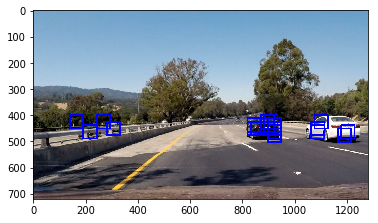

Scale:  1


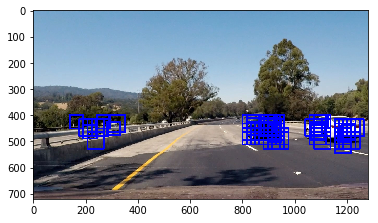

Scale:  1.25


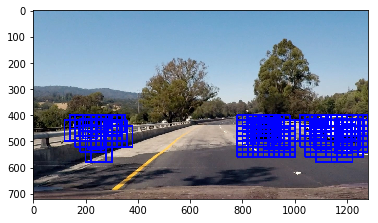

Scale:  1.5


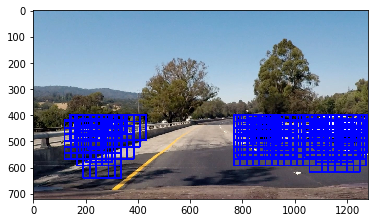

Scale:  1.75


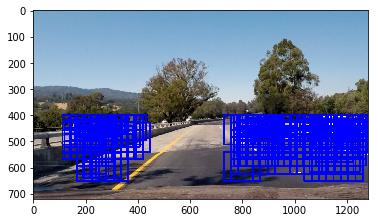

Scale:  2


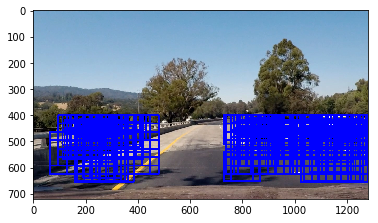

In [23]:
img = mpimg.imread(test_images[2])
view_image_w_boxes(img, 400, 656, 0.8)
view_image_w_boxes(img, 400, 656, 1)
view_image_w_boxes(img, 400, 656, 1.25)
view_image_w_boxes(img, 400, 656, 1.5)
view_image_w_boxes(img, 400, 656, 1.75)
view_image_w_boxes(img, 400, 656, 2)



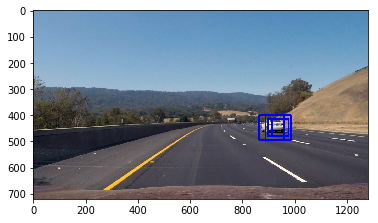

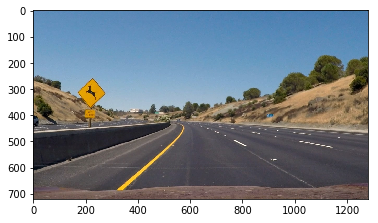

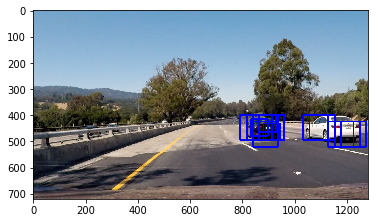

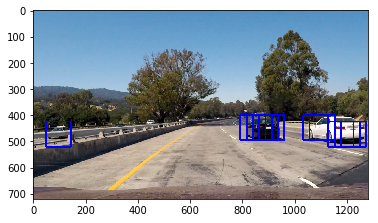

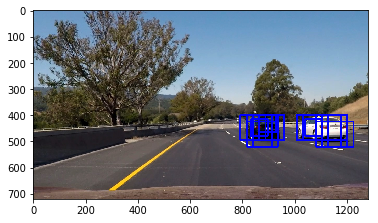

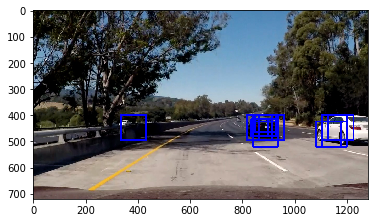

In [47]:
ystart = 400
ystop = 656

for img_file in test_images:
    img = mpimg.imread(img_file)
    
    bboxes1 = find_cars(img, ystart, ystop, 1, classifier, X_scaler, orient, 
                        pix_per_cell, cell_per_block, spatial_size, hist_bins)

    bboxes2 = find_cars(img, ystart, ystop, 1.5, classifier, X_scaler, orient, 
                        pix_per_cell, cell_per_block, spatial_size, hist_bins)

    
    for bbox in bboxes1:
        cv2.rectangle(img,bbox[0], bbox[1],(0,0,255),6) 
    for bbox in bboxes2:
        cv2.rectangle(img,bbox[0], bbox[1],(0,0,255),6) 


    plt.imshow(img)
    plt.show()

## Image Processing Pipeline

In [48]:
# Define a class to aggregate and average final boxes across images
class Boxes:
    def __init__(self):
        self._n_iterations = 10 #number of iterations to average boxes over        
        self._bboxes_all = [] #boxes from all iterations        
        
    #array holding all bboxes for each iteration
    @property
    def bboxes(self):
        #combine boxes for _n_iterations previous frames
        result = [item for sublist in self._bboxes_all for item in sublist]                
        return result

    @bboxes.setter
    def bboxes(self, value): 
        if len(self._bboxes_all) >= self._n_iterations:
            self._bboxes_all.pop(0)        
        self._bboxes_all.append(value)       


In [49]:
all_boxes = Boxes()

In [50]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [51]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [52]:
def labels_to_boxes(labels):
    found_boxes = []
    # Iterate through all detected cars        
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        found_boxes.append(bbox)
    return found_boxes    

In [53]:
def draw_labeled_bboxes(img, bboxes):
    # Iterate through all boxes
    for bbox in bboxes:
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [77]:
def process_image(image, ystart, ystop, classifier, X_scaler, orient,
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_heatmap=False, average_boxes = True):
    
    bbox_array = []
    for scale in [1, 1.5]:        
        boxes = find_cars(image, ystart, ystop, scale, classifier, X_scaler, orient, 
                            pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bbox_array.append(boxes)

    bboxes = [item for sublist in bbox_array for item in sublist]
    
    if average_boxes:
        all_boxes.bboxes = bboxes
        processed_bboxes = all_boxes.bboxes
    else:
        processed_bboxes = bboxes
        
    #Heat map for each box in box list
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, processed_bboxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)    
    final_boxes = labels_to_boxes(labels)
    
    if show_heatmap: 
        return draw_labeled_bboxes(np.copy(image), final_boxes), heatmap
    else:
        return draw_labeled_bboxes(np.copy(image), final_boxes)       


In [ ]:
    ncols = 2
    nrows = 6
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches(10.5, 35.5)
    feature_image = img
    
    i = 0
    for color_space in ["RGB", "HSV", "LUV", "HLS", "YUV", "YCrCb"]:
        if color_space == "HSV":
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
        features, hog_img =  get_hog_features(feature_image[:,:,0], orient=9, pix_per_cell=8, cell_per_block=8, 
                                    vis=True, feature_vec=True)

        axes[i][0].imshow(img)
        axes[i][0].set_title(color_space)
        axes[i][1].imshow(hog_img)            

        i += 1
    plt.show()


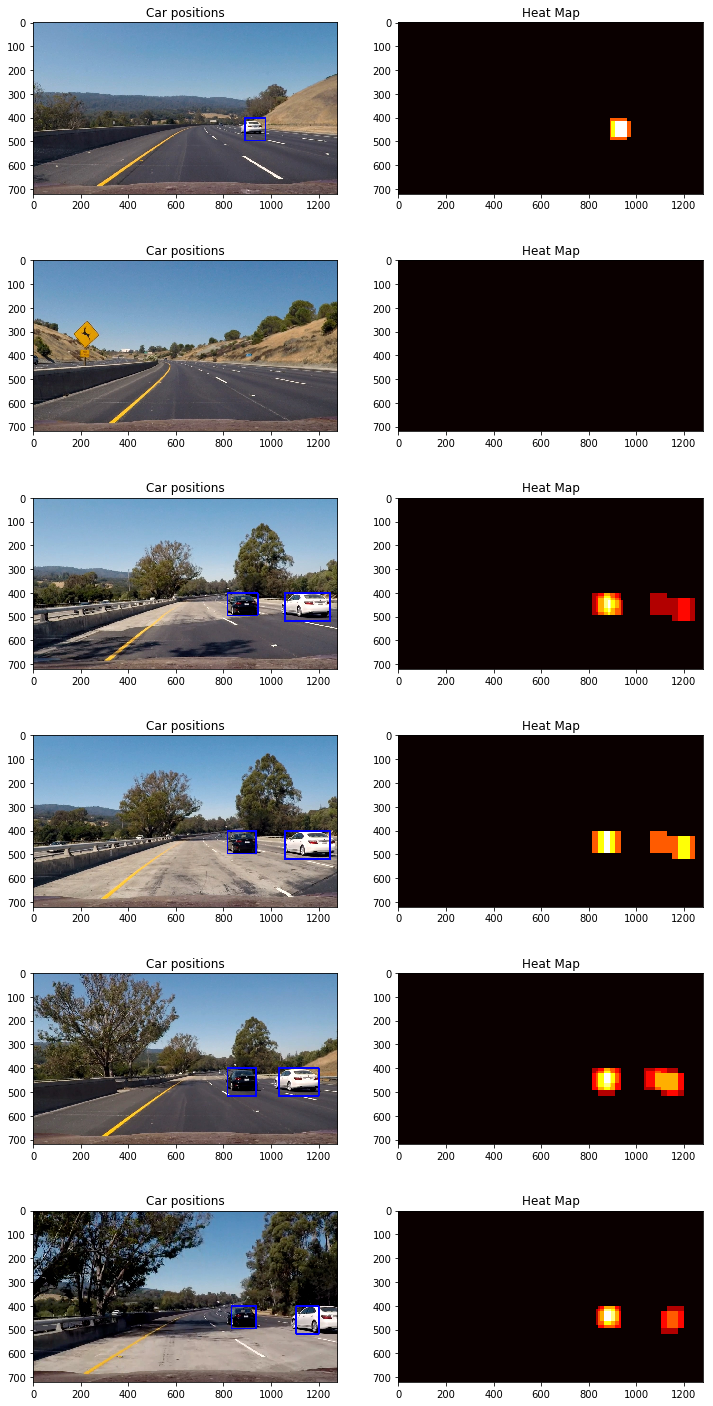

In [123]:
all_boxes = Boxes()
ncols = 2
nrows = 6
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(12, 25.5)
i = 0
    
for img_file in test_images:
    img = mpimg.imread(img_file)   
    
    ystart = 400
    ystop = 656    
    
    draw_img, heatmap = process_image(img, ystart, ystop, classifier, X_scaler, orient,
                                      pix_per_cell, cell_per_block, spatial_size, hist_bins, show_heatmap=True,
                                      average_boxes=False)

    axes[i][0].imshow(draw_img)
    axes[i][0].set_title('Car positions')
    axes[i][1].imshow(heatmap, cmap='hot')            
    axes[i][1].set_title('Heat Map')
    
    i += 1

plt.show()

Output of scipy.ndimage.measurements.label() on the heatmap from the last image:

2 cars found


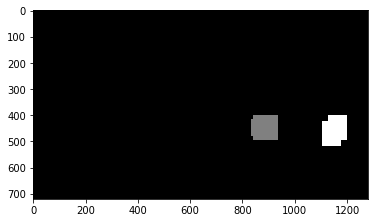

In [64]:
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
plt.show()

The resulting bounding boxes are drawn onto the last frame in the series:

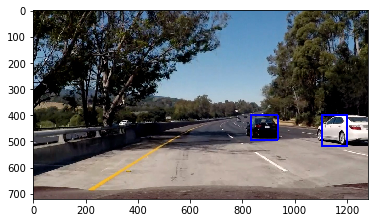

In [72]:
image = mpimg.imread(test_images[5])
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels_to_boxes(labels))
# Display the image
plt.imshow(draw_img)
plt.show()

## Process Videos

In [61]:
all_boxes = Boxes()
video_file = "project_video.mp4"

In [62]:
ystart = 400
ystop = 656

In [63]:
input_video = VideoFileClip("videos/" + video_file)
output_video = input_video.fl_image(lambda img: process_image(img, ystart, ystop, classifier, X_scaler, orient, 
                        pix_per_cell, cell_per_block, spatial_size, hist_bins))
output_video.write_videofile("output_videos/ "+ video_file, audio=False)

[MoviePy] >>>> Building video output_videos/ project_video.mp4
[MoviePy] Writing video output_videos/ project_video.mp4



 12%|█▏        | 152/1261 [02:11<16:00,  1.16it/s]


 24%|██▍       | 303/1261 [04:22<13:44,  1.16it/s]


 36%|███▌      | 454/1261 [06:33<11:40,  1.15it/s]


 48%|████▊     | 605/1261 [08:45<09:59,  1.09it/s]


 60%|█████▉    | 756/1261 [10:56<07:29,  1.12it/s]


 72%|███████▏  | 907/1261 [13:09<05:08,  1.15it/s]


 84%|████████▍ | 1057/1261 [15:24<04:03,  1.19s/it]


 96%|█████████▌| 1205/1261 [17:33<00:51,  1.08it/s]


100%|█████████▉| 1260/1261 [18:21<00:00,  1.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/ project_video.mp4 

